<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=133580513" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import spx_strategies as ss
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/spx-option-spread-backtester/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)



#########################
# Settings for backtest #
#########################
# Delta values must be scaled from 0.0 to 1.0 (0 delta to 100 delta)
delta_sp = 0.214
delta_lp = 0.001
delta_sc = 0.201
delta_lc = 0.001
delta_params = {'delta_sp':delta_sp, 'delta_lp':delta_lp, 'delta_sc':delta_sc,'delta_lc':delta_lc}

same_day = False
purchase_time = '15:45:00'

# Max loss is % : max_loss * amount_collected is exit criteria
max_loss = 100

# In dollars
commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0


files = [
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
#    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
    #f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
 #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1545_1600.csv"
  #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2018_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2017_1545_1600.csv"
  # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2016_1545_1600.csv"
  #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1dte_all.csv"
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1dte_all.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1dte_all.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1dte_all.csv"
]
li = []
for f in files:   
    df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()

if 'dte' not in df:
    df['dte'] = ((df['expiration'] - df['quote_date']) / np.timedelta64(1, 'D')).astype('int')

initial_portfolio_value = df.loc[1,'price']*20

df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

Copying db file to output : optimal-short-straddle-study_2021-2022_1DTE_1.db
Copying db file to output : optimal-iron-condor-study_2022_1.db
Copying db file to output : optimal-iron-condor-study.db


# New strategy schema focused on static and dynamic entry and exit policies

This code will be moved to a plugin notebook after it is stable

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from abc import ABC, abstractmethod

#########
# Abstract Strategy & Abstract Policy
#########

class AbstractStrategy(ABC):
    def __init__(self, entry_policy, exit_policy, df_ty, initial_portfolio_value, commission = 1.5, debug = False):
        self.entry_policy = entry_policy
        self.exit_policy = exit_policy
        self.commission = commission
        self.initial_portfolio_value = initial_portfolio_value
        self.df_ty = df_ty
        self.debug = debug
        self.df_trades = None
       
    def performCalcs(self):
        df_trades = self.df_trades
        df_trades['commission'] = df_trades['trade_count']*commission
        df_trades['lost'] = df_trades['lost_c'] + df_trades['lost_p']
        df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']
        df_trades['portfolio_value'] = 0.0
        #df_trades['daily_return'] = 0.0
        #df_trades['margin_utilization']=0.0
        initial_portfolio_value = self.initial_portfolio_value
        df_trades['net_cumsum']=df_trades['net'].cumsum()

        df_trades['portfolio_value'] = initial_portfolio_value + df_trades['net_cumsum']
        df_trades['transaction_return'] = df_trades['net'] / df_trades['portfolio_value'].shift(1)
        net = df_trades['net'].iloc[0]
        df_trades.loc[0,'transaction_return'] = df_trades['net'].iloc[0] / initial_portfolio_value
        df_trades['cum_return'] = (df_trades['portfolio_value'] - initial_portfolio_value) / initial_portfolio_value

        df_ty = self.df_ty.copy()
        df_ty['daily_risk_free_return'] = (df_ty['Adj Close'] / 252) / 100
        df_ty.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

        df_trades = pd.merge(df_trades, df_ty, left_on='trade_date', right_on='Date')
        df_trades.drop(['Date'],axis=1,inplace=True)

        # if you want to scale the chart, you should do it here
        factor = 1.0
        df_trade_plot = df_trades.copy()
        df_trade_plot['net'] = df_trade_plot['net']*factor
        df_trade_plot.set_index('expiration', inplace=True)
        df_trade_plot = df_trade_plot['net'].cumsum()
        
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        secax = ax.secondary_yaxis('right', functions=(self.net2pct, self.pct2net))
        secax.set_ylabel('% return')
        df_trade_plot.plot(ax=ax)
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"{str(self)}.png")
        if self.debug == False:
            plt.close(fig)

        df_trades_transaction_return = df_trades.copy()
        df_trades_transaction_return['transaction_return'] *= 100 
        df_trades_transaction_return.set_index('expiration', inplace=True)
        fig = plt.figure()
        ax = df_trades_transaction_return['transaction_return'].plot(linestyle='None', marker="o")
        ax.set_ylabel('Transaction Return %')
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"daily_ret_{str(self)}.png")
        if self.debug == False:
            plt.close(fig)
        

        trade_count = df_trades.shape[0]
        win_count = df_trades[df_trades['net']>0].shape[0]
        loss_count = df_trades[df_trades['net']<0].shape[0]
        std_trans_return = df_trades['transaction_return'].std()
        std_trans_return_less_rf = (df_trades['transaction_return'] - df_trades['daily_risk_free_return']).std()
        self.df_trades = df_trades
        if self.debug:
            print("*****  BACKTEST RESULTS  ****")
            print(
                f"\n{'Cumulative return:':<35}{round(df_trades['cum_return'].iloc[-1]*100,3):>10} %",
                f"\n{'Max Drawdown:':<35}{round(df_trades['cum_return'].min()*100,3):>10} %",
                f"\n{'Trading Days:':<35}{trade_count:>10}",
                f"\n{'Wins:':<35}{win_count:>10}",
                f"\n{'Losses:':<35}{loss_count:>10}",
                f"\n{'Breakeven:':<35}{df_trades[df_trades['net']==0.0].shape[0]:>10}",
                f"\n{'Win/Loss Ratio:':<35}{round(win_count/trade_count*100,3):>10} %",
                f"\n{'Mean Win:':<35}{round(df_trades[df_trades['net']>0]['net'].mean(),3):>10} $",
                f"\n{'Mean Win Trans Return:':<35}{round(df_trades[df_trades['transaction_return']>0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Loss:':<35}{round(df_trades[df_trades['net']<0]['net'].mean(),3):>10} $",
                f"\n{'Mean Loss Trans Return:':<35}{round(df_trades[df_trades['transaction_return']<0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Net Trans:':<35}{round(df_trades['net'].mean(),3):>10} $",
                f"\n{'Mean Trans Return:':<35}{round(df_trades['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Std Dev of Net Trans:':<35}{round(df_trades['net'].std(),3):>10}",
                f"\n{'Std Dev of Trans Return:':<35}{round(df_trades['transaction_return'].std(),3):>10}",
                f"\n{'Max Loss:':<35}{round(df_trades['net'].min(),3):>10} $",
                f"\n{'Max Win:':<35}{round(df_trades['net'].max(),3):>10} $",
                f"\n{'Sharpe Ratio static STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return,3):>10}",
                f"\n{'Sharpe Ratio with RF STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return_less_rf,3):>10}",
                f"\n{'Risk Adj Cumulative Return:':<35}{round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3):>10}",
                f"\n"
            )
            
        # The reason this number outputs like this, is because we were running a optimizer,
        # and we wanted a single "fitness" value that the optimizer could optimize
        # TODO : if Debug = True, output a dictionary with all of the values above
        risk_adj_cum_return = round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3)
        return risk_adj_cum_return
        
    def net2pct(self,x):
        return (x / initial_portfolio_value)*100

    def pct2net(self,x):
        return initial_portfolio_value * x/100
        
    @abstractmethod
    def evaluate(self,df):
        pass
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractPolicy(ABC):
    def getRoundedSlippedPrice(self,bid,ask, trans_type):
        mid = (bid + ask)/0.02
        if mid % 1 != 0.0:
            # We need to slip the bid/ask spread
            if trans_type == 'sell':
                ask -= 0.05
            elif trans_type=='buy':
                bid += 0.05

        mid = round((bid + ask)/0.02,1)
        return mid
    
    def get_contract_strike(self, curr_date, contract_date, target_delta, i_df, trans_type):
        # -1 means no delta should be selected
        if target_delta ==-1:
            return pd.Series([0,0,0])
#         df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
        df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)]
    
        if len(df1) == 0:
            print(f"WARNING : get_contract_strike no records found: {curr_date}, {contract_date}")
            return pd.Series([0,0,0])
        
        df1 = df1.iloc[0]
        rounded_price = self.getRoundedSlippedPrice(df1['ask'],df1['bid'],trans_type)

        
        return pd.Series([df1['strike'],df1['delta'],rounded_price])
    
    def get_amount_lost(self,df,row):
        contract_date = row['expiration']
        df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')]
        underlying = df1['price']
        
        if len(underlying)==0:
            raise Exception(f"Fatal error. Underlying price not found for date : {contract_date} and time : '16:00:00'")
        
        underlying = underlying.iloc[0]
        
        total_lost_c = 0.0
        total_lost_p = 0.0
        for col in row.index.values:
            if 'strike_sc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c + (underlying - row[col])*100
            if 'strike_lc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c - (underlying - row[col])*100
            if 'strike_sp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p + (row[col] - underlying)*100
            if 'strike_lp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p - (row[col] - underlying)*100
        return pd.Series([total_lost_c, total_lost_p])

    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass

In [3]:
#########
# AbstractEntry, AbstractDynamicEntryPolicy, AbstractStaticEntryPolicy
#########

class AbstractEntryPolicy(AbstractPolicy):
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass

class AbstractDynamicEntryPolicy(AbstractEntryPolicy):
    def __init__(self,commission):
        super().__init__(commission)
    
    @abstractmethod
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    
class AbstractStaticEntryPolicy(AbstractEntryPolicy):
    def __init__(self,commission, dte, trade_time):
        self.dte = dte
        self.trade_time = trade_time
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass

In [4]:
#####
# Dynamic Entry Policies
#####

class AlwaysOpenShortStraddleDynamicEntryPolicy(AbstractDynamicEntryPolicy):
    def __init__(self, commission, dte, delta_sp, delta_sc):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.dte = dte
        self.summary = f"Dynamic Entry Short Straddle. SP Delta : {delta_sp} SC Delta : {delta_sc}"
        super().__init__(commission)
    
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        df_trades = None
        if (df_trade_row is None or (df_trade_row['expiration'] == eval_date and eval_time=='16:00:00') or df_trade_row['expiration'] < eval_date or df_trade_row['lost_p']>0 or df_trade_row['lost_c']>0):
            #populate a new trade
            strike_sc, delta_sc, collected_sc, strike_sp, delta_sp, collected_sp, trade_count = 0,0,0,0,0,0,0
            expiration_p, expiration_c = None, None

            # create call/put dataframe slice if needed
            df_purchase_time = df_data[(df_data['dte']==self.dte) & (df_data['quote_time'] == eval_time)]
            df_c = df_purchase_time[(df_purchase_time['type']=="C")]
            df_p = df_purchase_time[(df_purchase_time['type']=="P")]
            
            if df_c.shape[0] == 0:
                if False:
                    print(f"***WARNING*** : No calls were found with static rules: {eval_date} | {eval_time}")
            else:
                ##### SHORT CALL #####
                expiration_c = df_c['expiration'].min()
                df_sc = df_c[(df_c['delta']<= self.delta_sc)]
                df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
                # print(f"get_contract_strike : {eval_date}, {expiration_c}, {self.delta_sc}, {df_sc.shape[0]}")
                strike_sc, delta_sc, collected_sc = self.get_contract_strike(eval_date, expiration_c,self.delta_sc, df_sc,'sell')

                
            if df_p.shape[0] == 0:
                if False:
                    print(f"***WARNING*** : No puts were found with static rules: quote date : {eval_date}")
            else:
                #### SHORT PUT ####
                expiration_p = df_p['expiration'].min()
                df_sp = df_p[(df_p['delta']<= self.delta_sp)]
                df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
                strike_sp, delta_sp, collected_sp = self.get_contract_strike(eval_date, expiration_p,self.delta_sp, df_sp,'sell')


            if strike_sc > 0.0:
                trade_count += 1
            if strike_sp > 0.0:
                trade_count += 1
                
            if trade_count == 0:
                return None

            if expiration_p is not None and expiration_c is not None and expiration_p != expiration_c:
                print("ERROR : put and call expirations are different within single straddle transaction. Trade nullified")
                return None
            else:
                expiration = expiration_p or expiration_c
            
            df_trades = pd.DataFrame([{'trade_date':eval_date, 'expiration':expiration, 'trade_count':trade_count, 
                               'delta_sc_target' : self.delta_sc,'delta_sp_target': self.delta_sp, 'strike_sc': strike_sc, 
                               'delta_sc':delta_sc, 'collected_sc': collected_sc, 'strike_sp': strike_sp,'delta_sp': delta_sp, 
                               'collected_sp': collected_sp, 'collected': collected_sc + collected_sp, 'lost_c': 0, 'lost_p' : 0}])
        
        return df_trades
    
    def __str__(self):
        self.summary

    def __repr__(self):
        self.summary

In [5]:
#### Basic Strategy Types

class StaticEntryDynamicExitStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv, timestep, debug = False):
            entry_policy = AbstractStaticEntryPolicy(commission, dte, trade_time)
            exit_policy = AbstractDynamicExitPolicy(commission, timestep)
            self.summary = f"{str(entry_policy)} {str(exit_policy)}"
            super().__init__(entry_policy, exit_policy, df_ty, ipv, commission, debug)

    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        
        
        self.df_trades['lost_c'] = 0.0
        self.df_trades['lost_p'] = 0.0
        
        df_times = pd.DataFrame(df['quote_time'].unique())
        df_times[0] = pd.to_datetime(df_times[0], format='%H:%M:%S').dt.time
        df_times.rename(columns={0: "quote_time"},inplace=True)
        df_times = df_times.sort_values(by='quote_time')
        
        start_time_timer = perf_counter()
        for index, trow in df_times.iterrows():           
            min_i = int(trow[0].strftime("%M"))
            curr_time = trow[0]
            start_time = time(hour=9, minute=30)
            end_time = time(hour=16)
            if (end_time < curr_time or curr_time <= start_time):
                continue
            str_quote_time = trow[0].strftime("%H:%M:%S")
            df_qt = df[(df['quote_time']==str_quote_time)]

            # print(f"Num rows at {str_quote_time} : {df_qt.shape[0]}")

            self.df_trades['trade_count'],self.df_trades['lost_c'], self.df_trades['lost_p'] = self.df_trades.apply(
                lambda row : self.exit_policy.evaluateTradingCondition(None, str_quote_time, row, df_qt), axis=1).T.values
            stop_time_timer = perf_counter()
            # print(df_trades.head())

            if min_i % 30 == 0:
                print(f"Processed {curr_time} | Elapsed : {stop_time_timer - start_time_timer}")
                start_time_timer = stop_time_timer
        
        return self.performCalcs()


    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticEntryHoldToExpStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv):
        entry_policy = AbstractStaticEntryPolicy(commission, dte, trade_time)
        exit_policy = AbstractStaticExitPolicy(commission, trade_time)
        self.summary = f"{str(entry_policy)} {str(exit_policy)}"
        super().__init__(entry_policy, exit_policy, df_ty, ipv, commission)
        
    def evaluate(df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class DynamicEntryDynamicExitStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv, debug = False):
            entry_policy = AbstractDynamicEntryPolicy(commission)
            exit_policy = AbstractDynamicExitPolicy(commission, None)
            self.summary = f"{str(entry_policy)} {str(exit_policy)}"
            self.df_trades = pd.DataFrame(columns=['trade_date', 'expiration', 'trade_count', 
                                                   'delta_sc_target','delta_sp_target', 'strike_sc', 
                                                   'delta_sc', 'collected_sc', 'strike_sp','delta_sp', 
                                                   'collected_sp', 'collected', 'lost_c', 'lost_p'])
            super().__init__(entry_policy, exit_policy, df_ty, ipv, commission, debug)

    def evaluate(self,df):
        df.loc[:,'quote_datetime'] = pd.to_datetime(df['quote_date'].astype(str)+' '+df['quote_time'].astype(str))
        df_datetimes = pd.DataFrame(df['quote_datetime'].unique())
        df_datetimes.rename(columns={0: "quote_datetime"},inplace=True)
        df_datetimes = df_datetimes.sort_values(by='quote_datetime')

        start_time_timer = perf_counter()
        df_dt = None
        for index, trow in df_datetimes.iterrows():
            day_i = int(trow[0].strftime("%d"))
            hour_i = int(trow[0].strftime("%H"))

            start_time = time(hour=9, minute=30)
            end_time = time(hour=16)
            curr_time = trow[0].time()
            str_quote_time = curr_time.strftime("%H:%M:%S")
            curr_date = pd.to_datetime(trow[0]).floor('D')

            if (end_time < curr_time or curr_time < start_time):
                continue

            # To save computation, pre-filter each time the date changes
            if df_dt is None or df_dt['quote_date'].iloc[0] != curr_date:
                df_dt = df[df['quote_date']==curr_date]
                #print(f"Iteration date : {curr_date} and time {str_quote_time}. DF rows {df.shape[0]}. df_dt rows : {df_dt.shape[0]}")

            # Design decision : we'll just try to enter and exit once each minute. This means that if we exit a position,
            # about 1 minute will pass before we decide to re-enter
            # 
            # To keep evalute trading decision method signature the same, we'll pass in a row: the last row of df_trades.
            # This leaves the possibility of having no rows.
            # Thus, every dynamic policy must account for getting no row.
            last_trade = None
            if self.df_trades.shape[0] > 0:
                last_trade = self.df_trades.iloc[-1]
            new_trade = self.entry_policy.evaluateTradingCondition(curr_date, str_quote_time, last_trade, df_dt)
            if new_trade is not None:
                self.df_trades = pd.concat([self.df_trades, new_trade], ignore_index=True)

            if self.df_trades.shape[0] > 0:
                last_trade = self.df_trades.iloc[-1]
            if last_trade is not None:
                if last_trade['expiration'] >= curr_date:
                    #print(f"call : evaluateTradingCondition {curr_date}, {str_quote_time}, {last_trade['expiration']}, {df_dt.shape[0]}")
                    trade_count, lost_c, lost_p = self.exit_policy.evaluateTradingCondition(curr_date, str_quote_time, last_trade, df_dt)
#                     if lost_c > 0 or lost_p > 0:
#                         print("Trying to propagate a loss into the future.")
                    self.df_trades.loc[self.df_trades.index[-1],'trade_count'] = trade_count
                    self.df_trades.loc[self.df_trades.index[-1],'lost_c'] = lost_c
                    self.df_trades.loc[self.df_trades.index[-1],'lost_p'] = lost_p

            
            
            stop_time_timer = perf_counter()

            if day_i == 28 and hour_i == 16:
                print(f"Processed {trow.iloc[0]} | Elapsed : {stop_time_timer - start_time_timer}")
                start_time_timer = stop_time_timer
        
        return self.performCalcs()


    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    


In [6]:
class AlwaysOpenShortStraddleDynamicEntryDynamicMaxLossExitStrategy(DynamicEntryDynamicExitStrategy):
    def __init__(self, commission, dte, delta_sp, delta_sc, df_ty, ipv, max_loss, debug = False):
            self.entry_policy = AlwaysOpenShortStraddleDynamicEntryPolicy(commission, dte, delta_sp, delta_sc)
            self.exit_policy = MaxLossDynamicExitPolicy(commission, None, max_loss)
            self.df_ty = df_ty
            self.initial_portfolio_value = ipv
            self.commission = commission
            self.debug = debug
            self.summary = f"Always open short straddle after max loss {max_loss}. SP : {delta_sp} SC : {delta_sc}"
            self.df_trades = pd.DataFrame(columns=['trade_date', 'expiration', 'trade_count', 
                                                   'delta_sc_target','delta_sp_target', 'strike_sc', 
                                                   'delta_sc', 'collected_sc', 'strike_sp','delta_sp', 
                                                   'collected_sp', 'collected', 'lost_c', 'lost_p'])

    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary

In [7]:
    
    
class AbstractExitPolicy(AbstractPolicy):
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractDynamicExitPolicy(AbstractExitPolicy):
    def __init__(self, commission, timestep):
        self.timestep = timestep
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, df):
        pass
    
    @abstractmethod
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    

    
class AbstractStaticExitPolicy(AbstractExitPolicy):
    def __init__(self,commission, trade_time):
        self.trade_time = trade_time
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, df):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    
    
class ShortStraddleStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.summary = f"Short Straddle. SP Delta : {delta_sp} SC Delta : {delta_sc}"
        super().__init__(commission, dte, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary

    
    def populateTrades(self, df):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        
        df_trades['delta_sc_target'] = self.delta_sc
        df_trades['delta_sp_target'] = self.delta_sp
        
        #TODO : Throw exception if no trades are found
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")
        
        df['delta_sc_target'] = self.delta_sc
        df['delta_sp_target'] = self.delta_sp
        
        # create call/put dataframe slice if needed
        df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        df_c = df_purchase_time[(df_purchase_time['type']=="C")]
        df_p = df_purchase_time[(df_purchase_time['type']=="P")]
        
        if df_c.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print("***WARNING*** : No puts were found with static rules.")
        
        ##### SHORT CALL #####
        df_sc = df_c[(df_c['delta']<= df_c['delta_sc_target'])]
        df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sc_target'], df_sc,'sell'), axis = 1).T.values
        
        #### SHORT PUT ####
        df_sp = df_p[(df_p['delta']<= df_p['delta_sp_target'])]
        df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sp_target'], df_sp,'sell'), axis = 1).T.values
        
            
        #TODO - clean this up. 
        for index, row in df_trades.iterrows():
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
                
        df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp'] 
        
        return df_trades
    
class ShortIronCondorStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.delta_lp = delta_lp
        self.delta_lc = delta_lc
        self.summary = f"Short Iron Condor. SP Delta : {round(delta_sp,3)} SC Delta : {round(delta_sc,3)} LP Delta : {round(delta_lp,3)} LC Delta : {round(delta_lc,3)}"
        super().__init__(commission, dte, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary


    
    def populateTrades(self, df):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        
        df_trades['delta_sc_target'] = self.delta_sc
        df_trades['delta_sp_target'] = self.delta_sp
        df_trades['delta_lc_target'] = self.delta_lc
        df_trades['delta_lp_target'] = self.delta_lp
        
        #TODO : Throw exception if no trades are found
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")
        
        df['delta_sc_target'] = self.delta_sc
        df['delta_sp_target'] = self.delta_sp
        df['delta_lc_target'] = self.delta_lc
        df['delta_lp_target'] = self.delta_lp
        
        # create call/put dataframe slice if needed
        df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        df_c = df_purchase_time[(df_purchase_time['type']=="C")]
        df_p = df_purchase_time[(df_purchase_time['type']=="P")]
        
        if df_c.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
        
        ##### SHORT CALL #####
        df_sc = df_c[(df_c['delta']<= df_c['delta_sc_target'])]
        df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sc_target'], df_sc, 'sell'), axis = 1).T.values
        
        #### SHORT PUT ####
        df_sp = df_p[(df_p['delta']<= df_p['delta_sp_target'])]
        df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sp_target'], df_sp, 'sell'), axis = 1).T.values
        
        ###### LONG CALL #####
        df_lc = df_c[(df_c['delta']>= df_c['delta_lc_target'])]# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
        df_lc = df_lc.loc[df_lc.groupby(['quote_date'])[['delta']].idxmin()['delta']]
        df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_lc_target'], df_lc, 'buy'), axis = 1).T.values
        df_trades['collected_lc'] = df_trades['collected_lc']*-1
            
        ###### LONG PUT #####
        df_lp = df_p[(df_p['delta']>= df_p['delta_lp_target'])]
        df_lp = df_lp.loc[df_lp.groupby(['quote_date'])[['delta']].idxmin()['delta']]
        df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_lp_target'], df_lp, 'buy'), axis = 1).T.values
        df_trades['collected_lp']=df_trades['collected_lp']*-1
            
        #TODO - clean this up. 
        for index, row in df_trades.iterrows():
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_lc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_lp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
                
        df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp'] + df_trades['collected_lc'] + df_trades['collected_lp']
        
        return df_trades

class HoldToExpStaticExitPolicy(AbstractStaticExitPolicy):
    def __init__(self, commission, trade_time):
        self.summary = f"Hold Until Expiration"
        super().__init__(commission, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    def populateTrades(self, df, df_trades):
        df_qt = df[(df['quote_time']==self.trade_time)&(df['dte']==0)]
        df_trades['lost_c'], df_trades['lost_p'] = df_trades.apply(
            lambda row : self.get_amount_lost(df_qt, row), axis=1).T.values
        return df_trades
    

    
class StaticShortIronCondorDynamicMaxLossExitStrategy(StaticEntryDynamicExitStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc, df_ty, ipv, max_loss, debug = False):
        self.entry_policy = ShortIronCondorStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc)
        self.exit_policy = MaxLossDynamicExitPolicy(commission, None, max_loss)
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __str__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __repr__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"
    
class StaticShortStraddleMaxLossExitStrategy(StaticEntryDynamicExitStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, df_ty, ipv, max_loss, debug = False):
        self.entry_policy = ShortStraddleStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc)        
        self.exit_policy = MaxLossDynamicExitPolicy(commission, None, max_loss)
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __str__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __repr__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"
    
class StaticShortStraddleHoldToExpStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, df_ty, ipv, debug = False):
        self.entry_policy = ShortStraddleStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc)
        self.exit_policy = HoldToExpStaticExitPolicy(commission, '16:00:00')
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticShortIronCondorHoldToExpStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc, df_ty, ipv, debug = False):
        self.entry_policy = ShortIronCondorStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc)
        self.exit_policy = HoldToExpStaticExitPolicy(commission, '16:00:00')
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class MaxLossDynamicExitPolicy(AbstractDynamicExitPolicy):
    def __init__(self, commission, timestep, max_loss):
        self.max_loss = max_loss
        self.drop_both_legs = False
        super().__init__(commission, timestep)
    
    def populateTrades(self, df):
        pass
    
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        row = df_trade_row
        expiration, collected, lost_c, lost_p, trade_count  = row['expiration'], row['collected'], row['lost_c'], row['lost_p'], row['trade_count']
        if lost_c > 0.0 or lost_p > 0.0:
            return pd.Series([trade_count, lost_c, lost_p])
        
        if (eval_time == '16:00:00' and eval_date == row['expiration']):
            #print(f"evaluating end of day")
            lost_c, lost_p = self.get_amount_lost(df_data,row)
#             if lost_c>0 or lost_p>0:
#                 print(f"We have a loss! eval_date {eval_date}, {df_trade_row}")
            return pd.Series([trade_count,lost_c, lost_p])

        eval_date = eval_date or expiration
        
        df1 = df_data[(df_data['quote_date'] == eval_date) & (df_data['expiration'] == expiration) & (df_data['quote_time']==eval_time)]
#         print(f"Num rows at {expiration} : {df1.shape[0]}")
        mark_to_market_c = 0.0
        mark_to_market_p = 0.0
        df_c = df1[df1['type']=='C']
        df_p = df1[df1['type']=='P']
        potential_trade_count = 0
        for col in row.index.values:
            opt_type = 'C'
            if 'strike_sc' in col and row[col] != 0.0:
                    df_sc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_sc, 'C', row[col], expiration, eval_time)
                    s_sc = df_sc.iloc[0]
                    mark_to_market_c -= self.getRoundedSlippedPrice(s_sc['ask'],s_sc['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lc' in col and row[col] != 0.0:
                    df_lc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_lc, 'C', row[col], expiration, eval_time)
                    s_lc = df_lc.iloc[0]
                    mark_to_market_c += self.getRoundedSlippedPrice(s_lc['ask'],s_lc['bid'],'sell')
                    potential_trade_count +=1
            opt_type='P'
            if 'strike_sp' in col and row[col] != 0.0:
                    df_sp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_sp, 'P', row[col], expiration, eval_time)
                    s_sp = df_sp.iloc[0]
                    mark_to_market_p -= self.getRoundedSlippedPrice(s_sp['ask'],s_sp['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lp' in col and row[col] != 0.0:
                    df_lp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_lp, 'P', row[col], expiration, eval_time)
                    s_lp = df_lp.iloc[0]
                    mark_to_market_p += self.getRoundedSlippedPrice(s_lp['ask'],s_lp['bid'],'sell')
                    potential_trade_count +=1
        
        potential_loss = collected + mark_to_market_c + mark_to_market_p
        
        #print(f"Potential Loss : {potential_loss} | collected : {collected}")
        
        if (potential_loss < 0) and (abs(potential_loss/collected) >= self.max_loss):
#             print(f"Exp: {expiration}. Eval time : {eval_time}. Collected : {collected}, MTMC : {mark_to_market_c}, MTMP : {mark_to_market_p}. Projected loss : {abs(potential_loss/collected)}")
#             print(df_sp.head(5))
            trade_count += potential_trade_count
            lost_c += -1*mark_to_market_c
            lost_p += -1*mark_to_market_p
#             print(f"early exit loss! : {row}, eval_date : {eval_date}. eval_time : {eval_time}")
                
        return pd.Series([trade_count,lost_c,lost_p])
    
    
    def len_check(self,df, opt_type, strike, contract_date, quote_time):
        if len(df)==0:
            raise Exception(f"Fatal error. Option Type {opt_type} | Strike : {strike} not found for date : {contract_date} and time : {quote_time}")
    
    def __str__(self):
        return f"Max Loss: {self.max_loss}"

    def __repr__(self):
        return f"Max Loss: {self.max_loss}"
    


In [8]:
# strat2 = AlwaysOpadd_suffixenShortStraddleDynamicEntryDynamicMaxLossExitStrategy(commission,1,0.04, 0.02, df_ty, initial_portfolio_value, 3, debug = True)
# sharp = strat2.evaluate(df)

# strat1 = StaticShortStraddleMaxLossExitStrategy(commission,1,purchase_time,0.08, 0.08, df_ty, initial_portfolio_value, 2, debug = True)
# sharp = strat1.evaluate(df)
# strat = StaticShortIronCondorHoldToExpStrategy(commission,1,purchase_time,0.09,0.09, 0.01, 0.01, df_ty, initial_portfolio_value, debug = True)
# strat = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,0.08,0.08, df_ty, initial_portfolio_value, debug = True)
# sharp = strat.evaluate(df)


# entry_policy = ShortStraddleStaticEntryPolicy(commission, 1, purchase_time, 0.04,0.02)
# df_trades = entry_policy.populateTrades(df)
# df_trades


Processed 10:00:00 | Elapsed : 22.585165861999997
Processed 10:30:00 | Elapsed : 21.803311925999992
Processed 11:00:00 | Elapsed : 21.588359744
Processed 11:30:00 | Elapsed : 21.414283425000008
Processed 12:00:00 | Elapsed : 21.22718893499996
Processed 12:30:00 | Elapsed : 21.23228559200004
Processed 13:00:00 | Elapsed : 21.149045153999964
Processed 13:30:00 | Elapsed : 21.538663885000005
Processed 14:00:00 | Elapsed : 21.122440179000023
Processed 14:30:00 | Elapsed : 21.206629058999965
Processed 15:00:00 | Elapsed : 21.33772833400002
Processed 15:30:00 | Elapsed : 21.221539989999997
Processed 16:00:00 | Elapsed : 21.144852399
*****  BACKTEST RESULTS  ****

Cumulative return:                     12.792 % 
Max Drawdown:                           0.202 % 
Trading Days:                             156 
Wins:                                     142 
Losses:                                    14 
Breakeven:                                  0 
Win/Loss Ratio:                        91.026 % 

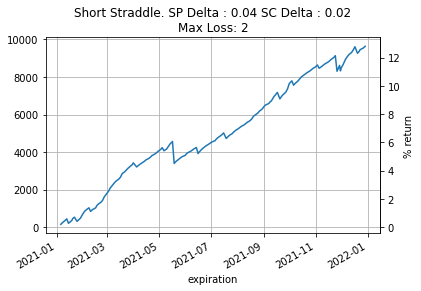

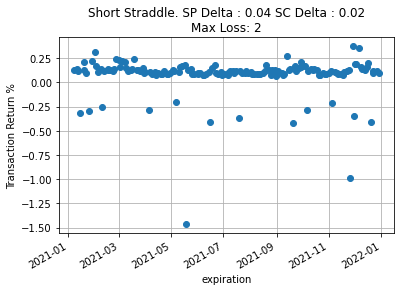

In [9]:
strat1 = StaticShortStraddleMaxLossExitStrategy(commission,1,purchase_time,0.04, 0.02, df_ty, initial_portfolio_value, 2, debug = True)
sharp = strat1.evaluate(df)

*****  BACKTEST RESULTS  ****

Cumulative return:                     18.695 % 
Max Drawdown:                           0.202 % 
Trading Days:                             156 
Wins:                                     155 
Losses:                                     1 
Breakeven:                                  0 
Win/Loss Ratio:                        99.359 % 
Mean Win:                             103.468 $ 
Mean Win Trans Return:                  0.124 % 
Mean Loss:                            -1956.0 $ 
Mean Loss Trans Return:                -2.194 % 
Mean Net Trans:                        90.266 $ 
Mean Trans Return:                       0.11 % 
Std Dev of Net Trans:                 169.727 
Std Dev of Trans Return:                0.002 
Max Loss:                             -1956.0 $ 
Max Win:                                312.0 $ 
Sharpe Ratio static STD:                9.023 
Sharpe Ratio with RF STD:               9.023 
Risk Adj Cumulative Return:          9714.516 



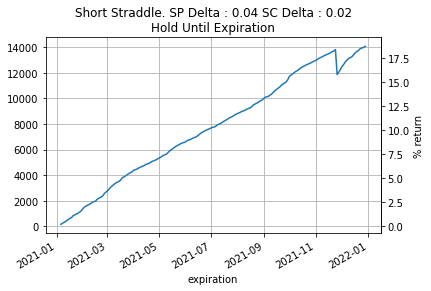

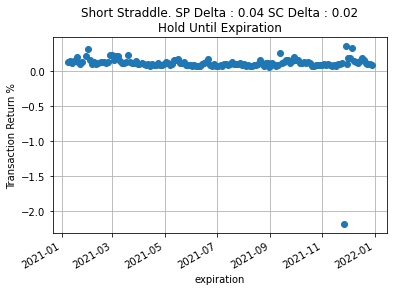

In [10]:
strat = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,0.04,0.02, df_ty, initial_portfolio_value, debug = True)
sharp = strat.evaluate(df)

In [11]:
def run_backtest(strat, df):
    return strat.evaluate(df)

In [12]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float("delta_sp", 0.002, 0.55)
#     delta_lp_trial = trial.suggest_float("delta_p_offset", 0.001, 0.5)
    delta_sc_trial = trial.suggest_float("delta_sc", 0.002, 0.55)
#     delta_lc_trial = trial.suggest_float("delta_c_offset", 0.001, 0.50)
#     max_loss = trial.suggest_float("max_loss", 1.25, 4.0)
   
    
    strategy = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,delta_sp_trial,delta_sc_trial, df_ty, initial_portfolio_value)
    score = run_backtest(strategy, df)
    return score

In [13]:
study_name = "optimal-short-straddle-study_2021-2022_1DTE_1"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, purchase_time), n_trials = 200)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-06-14 15:42:14,628] Using an existing study with name 'optimal-short-straddle-study_2021-2022_1DTE_1' instead of creating a new one.
[I 2023-06-14 15:42:17,611] Trial 402 finished with value: 9511.887 and parameters: {'delta_sp': 0.03826309194519847, 'delta_sc': 0.020878133034839562}. Best is trial 179 with value: 33261.224.


[I 2023-06-14 15:42:20,267] Trial 403 finished with value: 34810.216 and parameters: {'delta_sp': 0.012170683472871535, 'delta_sc': 0.0022938418369542624}. Best is trial 403 with value: 34810.216.


[I 2023-06-14 15:42:22,926] Trial 404 finished with value: 18812.814 and parameters: {'delta_sp': 0.02737989441193499, 'delta_sc': 0.0025621404331155565}. Best is trial 403 with value: 34810.216.
[I 2023-06-14 15:42:25,623] Trial 405 finished with value: 42271.749 and parameters: {'delta_sp': 0.012470156177995996, 'delta_sc': 0.011678538771456885}. Best is trial 405 with value: 42271.749.
[I 2023-06-14 15:42:28,546] Trial 406 finished with value: 5101.974 and parameters: {'delta_sp': 0.14971544567391312, 'delta_sc': 0.012004312428218459}. Best is trial 405 with value: 42271.749.


[I 2023-06-14 15:42:31,275] Trial 407 finished with value: 23485.843 and parameters: {'delta_sp': 0.0021919429813252837, 'delta_sc': 0.030783375005681665}. Best is trial 405 with value: 42271.749.
[I 2023-06-14 15:42:33,992] Trial 408 finished with value: 44038.999 and parameters: {'delta_sp': 0.02149369966225584, 'delta_sc': 0.020866720681090124}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:42:36,708] Trial 409 finished with value: 10610.959 and parameters: {'delta_sp': 0.04186150317126989, 'delta_sc': 0.026052979839447436}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:42:39,447] Trial 410 finished with value: 7902.175 and parameters: {'delta_sp': 0.05330666256672662, 'delta_sc': 0.021663620950010176}. Best is trial 408 with value: 44038.999.


[I 2023-06-14 15:42:42,134] Trial 411 finished with value: 19704.869 and parameters: {'delta_sp': 0.029559142917636155, 'delta_sc': 0.0021446482739845146}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:42:44,872] Trial 412 finished with value: 13152.541 and parameters: {'delta_sp': 0.020387188203358157, 'delta_sc': 0.04330280616071962}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:42:47,787] Trial 413 finished with value: 19401.785 and parameters: {'delta_sp': 0.02163329989274553, 'delta_sc': 0.03366408801104461}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:42:50,549] Trial 414 finished with value: 292.038 and parameters: {'delta_sp': 0.011612750413059175, 'delta_sc': 0.27728207539084887}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:42:53,293] Trial 415 finished with value: 11509.152 and parameters: {'delta_sp': 0.03678023325939944, 'delta_sc': 0.017035093928533373}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:42:55,982

[I 2023-06-14 15:43:56,122] Trial 438 finished with value: 1332.527 and parameters: {'delta_sp': 0.002085287758464942, 'delta_sc': 0.15039686661837934}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:43:58,832] Trial 439 finished with value: 7127.654 and parameters: {'delta_sp': 0.09313531159138827, 'delta_sc': 0.0258866873318074}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:44:01,512] Trial 440 finished with value: 11083.414 and parameters: {'delta_sp': 0.03709244166098272, 'delta_sc': 0.04636025978794422}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:44:04,201] Trial 441 finished with value: 35111.135 and parameters: {'delta_sp': 0.02157882161054452, 'delta_sc': 0.02468580200513129}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:44:06,914] Trial 442 finished with value: 7347.808 and parameters: {'delta_sp': 0.05040555602282647, 'delta_sc': 0.05564085214196127}. Best is trial 408 with value: 44038.999.
[I 2023-06-14 15:44:09,628] Trial

[I 2023-06-14 15:50:11,285] Trial 576 finished with value: 3047.591 and parameters: {'delta_sp': 0.23048208773309625, 'delta_sc': 0.0020548133026279253}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:50:14,012] Trial 577 finished with value: 7159.749 and parameters: {'delta_sp': 0.052446512837289405, 'delta_sc': 0.015456314934983627}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:50:16,701] Trial 578 finished with value: 6825.397 and parameters: {'delta_sp': 0.04214315723486547, 'delta_sc': 0.010076920323546696}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:50:19,420] Trial 579 finished with value: 42691.572 and parameters: {'delta_sp': 0.02136798938483437, 'delta_sc': 0.017272676165103622}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:50:22,146] Trial 580 finished with value: 13278.993 and parameters: {'delta_sp': 0.03132741351209742, 'delta_sc': 0.009249288259284285}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:50:24,856

[I 2023-06-14 15:50:30,277] Trial 583 finished with value: 37374.547 and parameters: {'delta_sp': 0.02023834573090621, 'delta_sc': 0.003758755860728163}. Best is trial 464 with value: 45572.758.


[I 2023-06-14 15:50:32,959] Trial 584 finished with value: 4996.728 and parameters: {'delta_sp': 0.12862797437390378, 'delta_sc': 0.003190470626973497}. Best is trial 464 with value: 45572.758.


[I 2023-06-14 15:50:35,681] Trial 585 finished with value: 8896.207 and parameters: {'delta_sp': 0.034587089889165944, 'delta_sc': 0.00407835649636373}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:50:38,374] Trial 586 finished with value: 5680.058 and parameters: {'delta_sp': 0.06560046141145542, 'delta_sc': 0.009640176009955323}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:50:41,024] Trial 587 finished with value: 41944.743 and parameters: {'delta_sp': 0.01661751753354057, 'delta_sc': 0.011637317514875513}. Best is trial 464 with value: 45572.758.


[I 2023-06-14 15:50:43,675] Trial 588 finished with value: 37361.826 and parameters: {'delta_sp': 0.018267309830296927, 'delta_sc': 0.003946663490327008}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:50:46,286] Trial 589 finished with value: 39691.003 and parameters: {'delta_sp': 0.0161084505904798, 'delta_sc': 0.007514275438773952}. Best is trial 464 with value: 45572.758.


[I 2023-06-14 15:50:49,035] Trial 590 finished with value: 35603.112 and parameters: {'delta_sp': 0.015789773991035115, 'delta_sc': 0.0025220448109742905}. Best is trial 464 with value: 45572.758.


[I 2023-06-14 15:50:51,784] Trial 591 finished with value: 35884.749 and parameters: {'delta_sp': 0.015880954894049663, 'delta_sc': 0.002445735768846924}. Best is trial 464 with value: 45572.758.


[I 2023-06-14 15:50:54,364] Trial 592 finished with value: 36041.08 and parameters: {'delta_sp': 0.014926433709435217, 'delta_sc': 0.0020572817423848005}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:50:57,113] Trial 593 finished with value: 41188.665 and parameters: {'delta_sp': 0.017227592850137075, 'delta_sc': 0.010973482757394617}. Best is trial 464 with value: 45572.758.


[I 2023-06-14 15:50:59,863] Trial 594 finished with value: 35109.181 and parameters: {'delta_sp': 0.016854069995991715, 'delta_sc': 0.0031019548238880035}. Best is trial 464 with value: 45572.758.


[I 2023-06-14 15:51:02,594] Trial 595 finished with value: 36488.944 and parameters: {'delta_sp': 0.016360622817863893, 'delta_sc': 0.002093804255122374}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:51:06,398] Trial 596 finished with value: 6229.651 and parameters: {'delta_sp': 0.11103188384299792, 'delta_sc': 0.014445055562476073}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:51:09,144] Trial 597 finished with value: 40971.0 and parameters: {'delta_sp': 0.014552139758447404, 'delta_sc': 0.01210319872822712}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:51:11,884] Trial 598 finished with value: 41931.731 and parameters: {'delta_sp': 0.010523486795676221, 'delta_sc': 0.011555562469449573}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:51:14,600] Trial 599 finished with value: 42787.722 and parameters: {'delta_sp': 0.011700623066321029, 'delta_sc': 0.012262601062366766}. Best is trial 464 with value: 45572.758.
[I 2023-06-14 15:51:17,28

Best Score:  45572.758
Best Params: 
  delta_sc: 0.024146510183899725
  delta_sp: 0.022907588850063103
